# Tweet Sentiment Analysis Using NLP

## Business Problem

- ~~Google data scientist, trying to gather data about how Google's products and services compare to Apple and how people feel about Google compared to Apple, trying to determine what they can use to improve since Apple is popular~~ include in next steps
- Using a model to predict the sentiment of consumers between Apple and Google products and services, we can see the preferences of consumers and try to highlight certain features between competitors to further improve Google products and services
- Easier to build model that can do this for us instead of individually reviewing thousands of reviews and survey responses. This is quicker and more efficient to make more informed decisions and to be able to respond to customers in a more timely manner (social media team, customer support team)
- By creating a model that can predict consumer sentiment, we can make decisions to maximize sales and customer satisfaction when launching new products and services as well, as well as track sentiment over time
- Analyze feelings of our target audience towards our brand

Customer feedback is a crucial part of the business of providing consumer products and services, as without feedback, we would be left not knowing how best to improve our products to appeal to our existing consumer base and reach out further to more people. 

## Data / EDA

Packages

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import nltk
from nltk import FreqDist
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import re

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from wordcloud import WordCloud
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline as imb_mkp

import warnings
warnings.filterwarnings('ignore')

Loading in dataset. Data contains sample of tweets from Twitter that have been labelled for us by human raters.

In [2]:
df = pd.read_csv('data/twitter_product_emotions.csv')
print(df.shape)
df.info()
df.head()

(8721, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Value counts in each column

In [3]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

Get rid of "I can't tell" tweets. For now these extra tweets will not be helpful in trying to create a model that can predict tweet sentiment.

In [4]:
unknown_emotion = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"].index

df.drop(unknown_emotion, inplace=True)
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

Checking if there are any null values in our data. More than half of the entries in our dataset have null values in the 'emotion_in_tweet_is_directed_at' column, which tells us what product the tweet was directed at, so it may not be a good idea to look at sentiment for Apple vs Google products.

In [5]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5410
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

Create new dataframe with only positive and negative emotion entries

In [6]:
# note to self: clean up code here later
neutral = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"].index

sentiment_df = df
sentiment_df.drop(neutral, inplace=True)
print(sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())
sentiment_df.head()

Positive emotion    2869
Negative emotion     545
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Examining most common words in tweets. To do this, we need to tokenize tweets

In [7]:
def tweet_tokenizer(df):
    """
    Takes in a dataframe of Twitter tweets and tokenizes each tweet for
    natural language processing. Converts each tweet to lowercase and 
    removes stopwords from each tweet. Returns a dataframe including the
    filtered tweets represented in columns.
    """
    tokenizer = TweetTokenizer()
    df['tokens'] = [tokenizer.tokenize(text) for text in df['tweet_text']]

    df['lower_tokens'] = df['tokens'].apply(lambda x: [w.lower() for w in x])

    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['@mention', '�', '#sxsw', '@sxsw', 'sxsw', 'rt', 'link']
    df['no_stops'] = df['lower_tokens'].apply(lambda x: [w for w in x if w not in stopwords_list])
    
    return df

In [8]:
sentiment_df = tweet_tokenizer(sentiment_df)
sentiment_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tokens,lower_tokens,no_stops
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[., @wesley83, I, have, a, 3G, iPhone, ., Afte...","[., @wesley83, i, have, a, 3g, iphone, ., afte...","[@wesley83, 3g, iphone, 3, hrs, tweeting, #ris..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[@jessedee, know, about, @fludapp, ?, awesome,...","[@jessedee, know, @fludapp, awesome, ipad, iph..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[@swonderlin, can, not, wait, for, #ipad, 2, a...","[@swonderlin, wait, #ipad, 2, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[@sxsw, i, hope, this, year's, festival, isn't...","[hope, year's, festival, crashy, year's, iphon..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW, :, ...","[@sxtxstate, great, stuff, on, fri, #sxsw, :, ...","[@sxtxstate, great, stuff, fri, marissa, mayer..."


Creating word cloud to visualize most common words in tweets

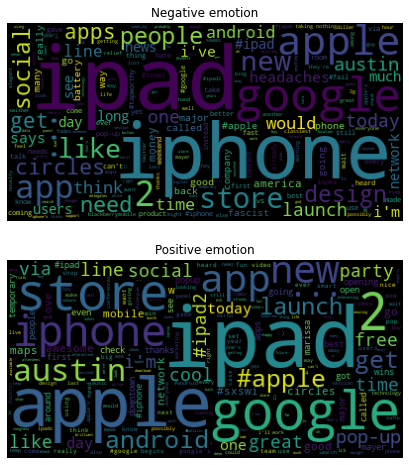

In [9]:
fig, axes = plt.subplots(2,1,figsize=(10,8))
for ax, emotion in zip(axes, sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()):
    tweet = sentiment_df.loc[sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'] == emotion,
                            'no_stops']
    tweet = tweet.str.join(' ')
    tweet = ' '.join(tweet)
    tweet = tweet.split(' ')
    fdist = FreqDist(tweet)
    wordcloud = WordCloud().generate_from_frequencies(fdist)

    ax.imshow(wordcloud)
    ax.set_title(emotion)
    ax.axis('off')
plt.show()

Further preprocessing and normalizing

In [10]:
lemmatizer = WordNetLemmatizer()
sentiment_df['lemmatized'] = sentiment_df['no_stops'].apply(lambda x:[lemmatizer.lemmatize(w) for w in x])
sentiment_df['lemmatized']

0       [@wesley83, 3g, iphone, 3, hr, tweeting, #rise...
1       [@jessedee, know, @fludapp, awesome, ipad, iph...
2               [@swonderlin, wait, #ipad, 2, also, sale]
3       [hope, year's, festival, crashy, year's, iphon...
4       [@sxtxstate, great, stuff, fri, marissa, mayer...
                              ...                        
8706    [pr, guy, convinced, switch, back, iphone, gre...
8708    [papyrus, ..., sort, like, ipad, nice, lol, la...
8709    [diller, say, google, tv, might, run, playstat...
8713    [i've, always, used, camera, iphone, b, c, ima...
8716                                   [ipad, everywhere]
Name: lemmatized, Length: 3414, dtype: object

In [11]:
sentiment_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tokens,lower_tokens,no_stops,lemmatized
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[., @wesley83, I, have, a, 3G, iPhone, ., Afte...","[., @wesley83, i, have, a, 3g, iphone, ., afte...","[@wesley83, 3g, iphone, 3, hrs, tweeting, #ris...","[@wesley83, 3g, iphone, 3, hr, tweeting, #rise..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[@jessedee, know, about, @fludapp, ?, awesome,...","[@jessedee, know, @fludapp, awesome, ipad, iph...","[@jessedee, know, @fludapp, awesome, ipad, iph..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[@swonderlin, can, not, wait, for, #ipad, 2, a...","[@swonderlin, wait, #ipad, 2, also, sale]","[@swonderlin, wait, #ipad, 2, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[@sxsw, i, hope, this, year's, festival, isn't...","[hope, year's, festival, crashy, year's, iphon...","[hope, year's, festival, crashy, year's, iphon..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW, :, ...","[@sxtxstate, great, stuff, on, fri, #sxsw, :, ...","[@sxtxstate, great, stuff, fri, marissa, mayer...","[@sxtxstate, great, stuff, fri, marissa, mayer..."


## Analysis

Splitting dataset into training and test sets before fitting models.

In [37]:
X = sentiment_df['lemmatized'].str.join(' ')
y = sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [38]:
X_train

184                                    #ipad 2 take video
210     hobo shotgun video game coming ipad iphone use...
6906    #tech even begin #apple win past week there's ...
857     think might go weekend without seeing ipad cas...
4690    andrew k prx equates homogeneity apple ecosyst...
                              ...                        
5277                    apple school marketing expert via
7873    woohoo go game launch do-it-yourself iphone sc...
4240    left brain search google right brain search x ...
2703    joined heaving river flow see marissa mayer go...
3259    y'all seen temp apple store going downtown wou...
Name: lemmatized, Length: 2731, dtype: object

Because classes are imbalanced, I use random oversampling, which randomly duplicates entries in the minority class and adds them to the training dataset. We only want to perform oversampling on the training dataset to train our models, as performing it on our test model would affect the integrity of our holdout data and the validity of our model [[source]]('https://stackoverflow.com/a/48810493').

In [39]:
print(sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True))

Positive emotion    0.840363
Negative emotion    0.159637
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64


In [56]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train, y_train)
X_train_vec = tfidf_vectorizer.transform(X_train)
y_train_vec = tfidf_vectorizer.transform(y_train)

smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_vec, y_train_vec)

In [76]:
X_train_resampled.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Random Forest model

In [100]:
rf_model = RandomForestClassifier()
tfidf_vectorizer = TfidfVectorizer()

rf_pipe = imb_mkp(tfidf_vectorizer, smote, rf_model)

scores = cross_val_score(rf_pipe, X_train, y_train)
print(scores)
print(np.mean(scores))

[0.86837294 0.87728938 0.88095238 0.87545788 0.87179487]
0.874773489764349


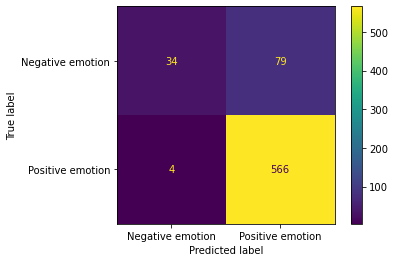

In [101]:
rf_pipe.fit(X_train, y_train)
plot_confusion_matrix(rf_pipe, X_test, y_test)

XGBoost classifier

In [98]:
xgb_model = XGBClassifier(eval_metric='auc')
tfidf_vectorizer = TfidfVectorizer()

xgb_pipe = imb_mkp(tfidf_vectorizer, smote, xgb_model)

scores = cross_val_score(xgb_pipe, X_train, y_train)
print(scores)
print(np.mean(scores))

[0.85557587 0.86996337 0.86630037 0.86630037 0.86080586]
0.8637891663485814


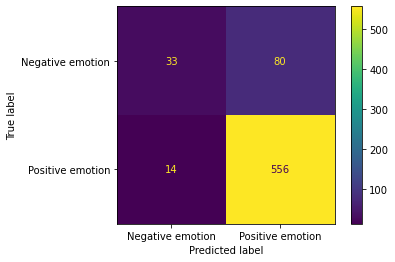

In [99]:
xgb_pipe.fit(X_train, y_train)
plot_confusion_matrix(xgb_pipe, X_test, y_test)

## Results

### Next Steps